In [6]:
import pandas as pd
import numpy as np
import os
from joblib import dump, load
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, cross_validate
from collections import Counter
from sklearn.metrics import accuracy_score
from pprint import pprint
import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

dados = pd.read_csv ("Databases/PDACCTRL_samplesXfeatures_RAW.csv", sep=',')
dados

,Sample_ID,Grupo,MIMAT0000062_st,MIMAT0000063_st,MIMAT0000064_st,MIMAT0000065_st,MIMAT0000066_st,MIMAT0000067_st,MIMAT0000068_st,MIMAT0000069_st,...,MIMAT0031119_st,MIMAT0031120_st,MIMAT0031175_st,MIMAT0031176_st,MIMAT0031177_st,MIMAT0031178_st,MIMAT0031179_st,MIMAT0031180_st,MIMAT0031181_st,y
0,GSM2278612,PDAC,1.129491,5.508052,2.923399,1.751963,0.693354,0.750790,0.685247,5.234038,...,0.913821,0.660219,0.484359,0.954552,1.271430,1.405966,0.597030,0.935637,0.930258,1
1,GSM2278613,PDAC,1.727870,7.021726,4.075586,1.692451,0.748297,0.819648,1.228891,3.863134,...,0.572489,0.288395,0.911395,0.865855,1.191414,1.248563,0.880128,0.443996,0.461034,1
2,GSM2278614,PDAC,1.275866,5.847073,4.037849,1.675842,0.792464,0.854456,0.427473,5.030710,...,0.567179,0.585677,0.968250,0.416603,0.906936,0.515170,0.373492,1.029657,0.783717,1
3,GSM2278615,PDAC,1.231164,5.372768,3.634441,1.629729,0.835388,0.508545,0.633179,4.395977,...,0.606826,0.616086,0.910045,0.485816,0.481710,0.658906,0.486607,1.092210,0.877583,1
4,GSM2278616,PDAC,1.598425,5.448495,3.763625,1.970805,0.652223,0.442908,0.477028,4.051217,...,0.798609,0.780584,0.655019,0.591214,1.120507,1.493095,0.723840,0.936191,0.714010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,GSM2278758,Controle,1.072158,6.132864,4.303285,1.466693,1.066174,0.743631,0.542135,4.761716,...,0.565492,0.494150,0.605459,0.665845,1.061685,0.433729,0.351924,0.844252,0.267246,0
103,GSM2278759,Controle,1.688142,5.986205,3.848825,2.162682,0.984778,0.885241,0.934689,4.002943,...,0.829502,0.562959,1.029765,0.616121,0.528186,1.066021,0.886998,0.823196,0.621138,0
104,GSM2278760,Controle,1.507370,5.871728,3.430393,1.897419,0.627474,0.908978,0.458824,4.791717,...,1.177363,0.819254,0.368961,0.541980,1.179273,0.513666,0.789142,1.221342,0.959684,0
105,GSM2278761,Controle,0.588391,6.057384,4.142099,1.870668,1.081216,0.611892,0.771683,5.097688,...,0.604917,0.446808,0.563384,0.238049,0.932333,0.753658,0.141102,1.277319,0.443357,0


In [7]:
#normalizar
dados_num = dados.drop(columns=["Sample_ID", "Grupo", "y"])
dados_cat =dados[["Grupo"]]

#Instaciar o objeto normalizador
normalizador = preprocessing.MinMaxScaler()
#treinar o modelo normalizador
modelo_normalizador_num = normalizador.fit(dados_num)
#Salvando modelo normalizador para uso posterior
os.makedirs('models_Tree', exist_ok=True)
dump(modelo_normalizador_num, open("models_Tree/normalizador_TCC_Tree.model" , "wb" ))

#normalizar os atributos numericos
dados_num_normalizado = modelo_normalizador_num.transform(dados_num)
# Normalizar os dados Categoricos
dados_cat_normalizado = pd.get_dummies(dados_cat, dtype='int', dummy_na=True)
# Converter dados numéricos normalizados para DataFrame
dados_num_df = pd.DataFrame(dados_num_normalizado, columns=dados_num.columns)
# unir atributos num e cat que foram normalizados
dados_final = dados_num_df.join(dados_cat_normalizado)
dados_final

,MIMAT0000062_st,MIMAT0000063_st,MIMAT0000064_st,MIMAT0000065_st,MIMAT0000066_st,MIMAT0000067_st,MIMAT0000068_st,MIMAT0000069_st,MIMAT0000070_st,MIMAT0000071_st,...,MIMAT0031175_st,MIMAT0031176_st,MIMAT0031177_st,MIMAT0031178_st,MIMAT0031179_st,MIMAT0031180_st,MIMAT0031181_st,Grupo_Controle,Grupo_PDAC,Grupo_nan
0,0.364020,0.616390,0.295100,0.357728,0.346143,0.246612,0.281153,0.791741,0.567829,0.293147,...,0.318945,0.485705,0.572516,0.820679,0.450881,0.418451,0.829685,0,1,0
1,0.566594,0.930115,0.621546,0.339320,0.389451,0.274622,0.596963,0.371203,0.940650,0.244754,...,0.753015,0.430443,0.524971,0.710573,0.730846,0.132892,0.395607,0,1,0
2,0.413573,0.686656,0.610854,0.334182,0.424265,0.288782,0.131408,0.729368,0.610426,0.575846,...,0.810807,0.150539,0.355937,0.197553,0.229818,0.473060,0.694120,0,1,0
3,0.398440,0.588351,0.496557,0.319919,0.458100,0.148070,0.250906,0.534658,0.831239,0.250591,...,0.751642,0.193662,0.103271,0.298098,0.341681,0.509392,0.780955,0,1,0
4,0.522772,0.604046,0.533159,0.425419,0.313721,0.121369,0.160196,0.428900,1.000000,0.237128,...,0.492416,0.259330,0.482838,0.881627,0.576288,0.418772,0.629635,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.344610,0.745889,0.686059,0.269489,0.640015,0.243700,0.198017,0.646852,0.622801,0.311664,...,0.442040,0.305828,0.447887,0.140583,0.208489,0.365372,0.216334,1,0,0
103,0.553144,0.715492,0.557298,0.484770,0.575855,0.301305,0.426057,0.414091,0.457515,0.127880,...,0.873334,0.274848,0.130887,0.582882,0.737640,0.353141,0.543719,1,0,0
104,0.491946,0.691766,0.438745,0.402720,0.294213,0.310961,0.149621,0.656055,0.669959,0.330950,...,0.201646,0.228655,0.517757,0.196500,0.640867,0.584396,0.856907,1,0,0
105,0.180837,0.730245,0.640391,0.394445,0.651872,0.190110,0.331365,0.749914,0.581655,0.119255,...,0.399272,0.039293,0.371028,0.364379,0.000000,0.616909,0.379254,1,0,0


In [8]:
# remover a classe 'Grupo_nan' por ser insignificante
#dados_filtered = dados[~dados['Management'].isin(['missing', 'simultaneous appendectomy'])].copy()
dados_filtered = dados_final.drop(columns=['Grupo_nan'])

# Segmentar os dados em atributos e classes
dados_classes = dados_filtered[['Grupo_Controle', 'Grupo_PDAC']]
dados_atributos = dados_filtered.drop(columns=['Grupo_Controle', 'Grupo_PDAC'])

# Preprocessamento
# Tratar colunas categóricas
dados_cat = dados_atributos.select_dtypes(include=['object']).columns
dados_cat_normalizado = pd.get_dummies(dados_cat, dtype='int')

# Tratar colunas numéricas
dados_num = dados_atributos.select_dtypes(include=['number']).columns

# Preencher NaNs numéricos com a média da coluna
dados_num_preenchido = dados_atributos[dados_num].fillna(dados_atributos[dados_num].mean())

# Juntar numéricos preenchidos e categóricos dummificados
dados_processados = pd.concat([dados_num_preenchido, dados_cat_normalizado], axis=1)

# Criar uma coluna de classe unificada (1 = PDAC, 0 = Controle)
# Isso transforma o DataFrame de 2 colunas em uma única Series binária
dados_classes_bin = np.where(dados_classes['Grupo_PDAC'] == 1, 1, 0)

# Construir o objeto SMOTE e executar o fit_resample
resampler = SMOTE(random_state=42)
dados_atributos_b, dados_classes_b = resampler.fit_resample(dados_processados, dados_classes_bin)

# Verificar a frequência das classes balanceadas
print('#### FREQUÊNCIA DAS CLASSES APÓS O BALANCEAMENTO ####')
print(Counter(dados_classes_b))

#### FREQUÊNCIA DAS CLASSES APÓS O BALANCEAMENTO ####
Counter({1: 88, 0: 88})


In [9]:
# Dicionario para armazenar os dados balanceados das classes
dados_balanceados = {}

print("Início do balanceamento")

# Loop para balancear cada classe (3x)
for classe in dados_classes.columns:
    print(f"\nBalanceando para a classe: '{classe}'")

    # Criar vetor binario para a classe atual: 1 se for essa classe, 0 caso contrário
    y_bin = dados_classes[classe]

    # Instanciar SMOTE com random_state para reprodutibilidade
    smote = SMOTE(random_state=42)

    # Aplicar o balanceamento com SMOTE
    X_res, y_res = smote.fit_resample(dados_processados, y_bin)

    # Exibir a contagem das classes após balanceamento
    print("Distribuição das classes após balanceamento:")
    print(Counter(y_res))

    # Armazenar os dados balanceados para essa classe
    dados_balanceados[classe] = (X_res, y_res)

Início do balanceamento

Balanceando para a classe: 'Grupo_Controle'
Distribuição das classes após balanceamento:
Counter({0: 88, 1: 88})

Balanceando para a classe: 'Grupo_PDAC'
Distribuição das classes após balanceamento:
Counter({1: 88, 0: 88})


In [10]:
# Treinar RandomForest por classe e calcular permutation importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

rf_models = {}
rf_importances = {}
rf_perm = {}

for classe, (X, y) in dados_balanceados.items():
    print(f"\nTreinamento com RandomForest para: {classe}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    rf = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # salvar
    nome_rf = f"modelo_RF_{classe.replace(' ', '_')}.joblib"
    caminho_rf = os.path.join(os.getcwd(), 'models_Tree', nome_rf)
    dump(rf, caminho_rf)
    print(f"RF salvo em: {caminho_rf}")

    # feature importances
    imp = rf.feature_importances_
    rf_models[classe] = rf
    rf_importances[classe] = imp

    # permutation importance (mais robusto)
    print('Calculando permutation importance (pode demorar) ...')
    perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    rf_perm[classe] = perm

    # mostrar top20 por impurity e por permutation
    cols = pd.Index(dados_processados.columns)
    imp_df = pd.DataFrame({'feature': cols, 'impurity_imp': imp}).sort_values('impurity_imp', ascending=False)
    perm_means = pd.Series(perm.importances_mean, index=cols)
    perm_df = perm_means.sort_values(ascending=False).rename('perm_mean')

    print('\nTop 20 (impurity)')
    print(imp_df.head(20))
    print('\nTop 20 (permutation)')
    print(perm_df.head(20))


print('\nRandomForest training + permutation importance completo.')


Treinando RandomForest para: Grupo_Controle
RF salvo em: c:\Users\cassi\OneDrive\Documentos\1-Programas\TCC\models_Tree\modelo_RF_Grupo_Controle.joblib
Calculando permutation importance (pode demorar) ...

Top 20 (impurity)
              feature  impurity_imp
1351  MIMAT0019059_st      0.062890
1249  MIMAT0018954_st      0.054768
997   MIMAT0015086_st      0.047727
1481  MIMAT0019745_st      0.039798
357   MIMAT0003251_st      0.032677
738   MIMAT0005829_st      0.028050
614   MIMAT0004784_st      0.025762
2541  MIMAT0030991_st      0.024030
1793  MIMAT0022264_st      0.020974
500   MIMAT0004518_st      0.019305
196   MIMAT0000765_st      0.019241
1     MIMAT0000063_st      0.018191
1570  MIMAT0019835_st      0.016541
992   MIMAT0015081_st      0.016081
1894  MIMAT0022723_st      0.013281
1218  MIMAT0018446_st      0.011976
2561  MIMAT0031011_st      0.011840
939   MIMAT0015025_st      0.011478
200   MIMAT0000773_st      0.011380
1283  MIMAT0018990_st      0.011332

Top 20 (permutatio

In [11]:
# Inspecionar árvore treinada (DecisionTree) - export_text (mostra top splits)
from sklearn.tree import export_text

for classe in ['Grupo_Controle', 'Grupo_PDAC']:
    modelo_path = os.path.join(os.getcwd(), 'models_Tree', f"modelo_{classe.replace(' ', '_')}.joblib")
    if os.path.exists(modelo_path):
        tree_model = load(modelo_path)
        print(f"\n--- Árvore para {classe} (primeiras 4 níveis) ---")
        try:
            tree_text = export_text(tree_model, feature_names=list(dados_processados.columns), max_depth=4)
            print(tree_text[:4000])  # limitar saída
        except Exception as e:
            print('Falha export_text:', e)
    else:
        print('Modelo não encontrado:', modelo_path)



--- Árvore para Grupo_Controle (primeiras 4 níveis) ---
|--- MIMAT0019745_st <= 0.46
|   |--- MIMAT0018938_st <= 0.27
|   |   |--- class: 1
|   |--- MIMAT0018938_st >  0.27
|   |   |--- MIMAT0027377_st <= 0.56
|   |   |   |--- class: 1
|   |   |--- MIMAT0027377_st >  0.56
|   |   |   |--- class: 0
|--- MIMAT0019745_st >  0.46
|   |--- MIMAT0004910_st <= 0.84
|   |   |--- class: 0
|   |--- MIMAT0004910_st >  0.84
|   |   |--- class: 1


--- Árvore para Grupo_PDAC (primeiras 4 níveis) ---
|--- MIMAT0019745_st <= 0.46
|   |--- MIMAT0021021_st <= 0.59
|   |   |--- MIMAT0004809_st <= 0.49
|   |   |   |--- class: 0
|   |   |--- MIMAT0004809_st >  0.49
|   |   |   |--- class: 1
|   |--- MIMAT0021021_st >  0.59
|   |   |--- class: 1
|--- MIMAT0019745_st >  0.46
|   |--- MIMAT0004910_st <= 0.84
|   |   |--- class: 1
|   |--- MIMAT0004910_st >  0.84
|   |   |--- class: 0




 Análise de Importância das Features na Random Forest
Figura salva: plots\MDI_Top15_Grupo_Controle.png


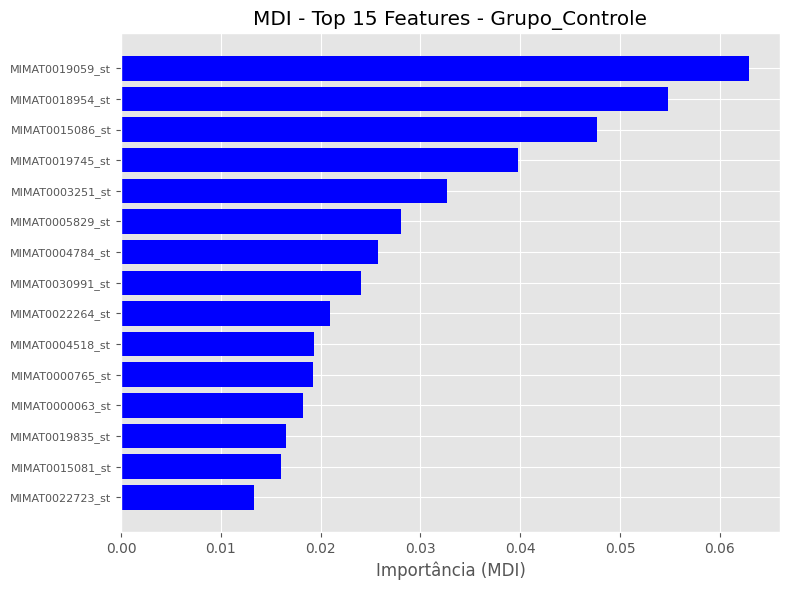

Figura salva: plots\Permutacao_Top15_Grupo_Controle.png


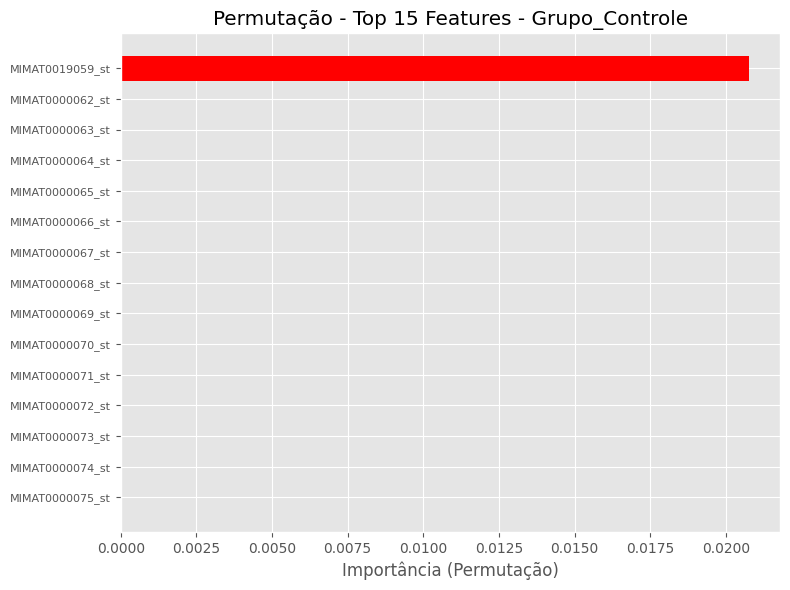

Figura salva: plots\MDI_Top15_Grupo_PDAC.png


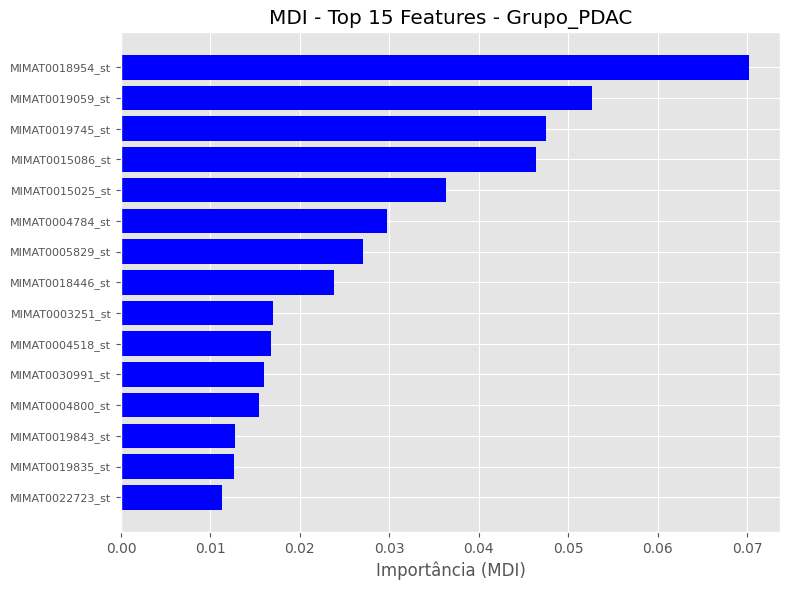

Figura salva: plots\Permutacao_Top15_Grupo_PDAC.png


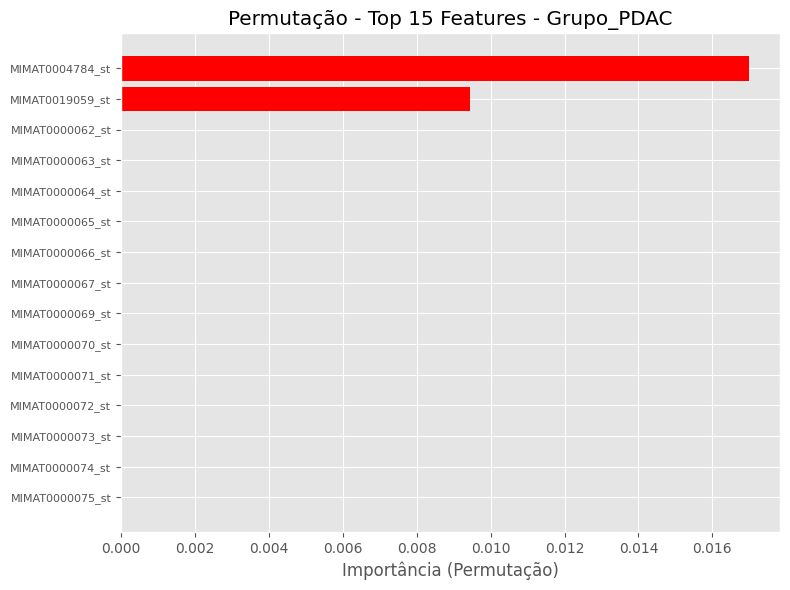


Correlação entre MDI e Permutação para Grupo_Controle: 0.4589

Correlação entre MDI e Permutação para Grupo_PDAC: -0.2324


In [12]:
# Visualizações para Random Forest (salvar 4 gráficos: MDI & Permutação por classe)
print("\n Análise de Importância das Features na Random Forest")

plt.style.use('ggplot')
# Criar pasta para salvar figuras (útil para incluir no TCC)
os.makedirs('plots', exist_ok=True)
top_k = 15  # número de features a exibir (ajustável)

for classe in ['Grupo_Controle', 'Grupo_PDAC']:
    if classe in rf_importances and classe in rf_perm:
        imp = rf_importances[classe]
        perm = rf_perm[classe]
        features = dados_processados.columns

        imp_df = pd.DataFrame({
            'Feature': features,
            'Importância (MDI)': imp,
            'Importância (Permutação)': perm.importances_mean
        })

        k = min(top_k, len(imp_df))

        # --- Gráfico 1: MDI (top k por MDI) ---
        top_mdi = imp_df.nlargest(k, 'Importância (MDI)').iloc[::-1]
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.barh(top_mdi['Feature'], top_mdi['Importância (MDI)'], color='blue')
        ax.set_title(f'MDI - Top {k} Features - {classe}')
        ax.set_xlabel('Importância (MDI)')
        ax.tick_params(axis='y', labelsize=8)
        plt.tight_layout()
        out_mdi = os.path.join('plots', f'MDI_Top{k}_{classe}.png')
        fig.savefig(out_mdi, dpi=300, bbox_inches='tight')
        print(f'Figura salva: {out_mdi}')
        plt.show()
        plt.close(fig)

        # --- Gráfico 2: Permutação (top k por Permutação) ---
        top_perm = imp_df.nlargest(k, 'Importância (Permutação)').iloc[::-1]
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.barh(top_perm['Feature'], top_perm['Importância (Permutação)'], color='red')
        ax.set_title(f'Permutação - Top {k} Features - {classe}')
        ax.set_xlabel('Importância (Permutação)')
        ax.tick_params(axis='y', labelsize=8)
        plt.tight_layout()
        out_perm = os.path.join('plots', f'Permutacao_Top{k}_{classe}.png')
        fig.savefig(out_perm, dpi=300, bbox_inches='tight')
        print(f'Figura salva: {out_perm}')
        plt.show()
        plt.close(fig)

# Imprimir correlação entre as métricas por classe
for classe in ['Grupo_Controle', 'Grupo_PDAC']:
    if classe in rf_importances and classe in rf_perm:
        mdi = rf_importances[classe]
        perm = rf_perm[classe].importances_mean
        try:
            corr = np.corrcoef(mdi, perm)[0,1]
        except Exception:
            corr = float('nan')
        print(f"\nCorrelação entre MDI e Permutação para {classe}: {corr:.4f}")

In [13]:
# CARREGAR NORMALIZADOR
normalizador = load(open("models_Tree/normalizador_TCC_Tree.model", "rb"))

# CARREGAR MODELOS RandomForest
caminho_modelos = os.path.join(os.getcwd(), 'models_Tree')
nomes_classes = ['Grupo_Controle', 'Grupo_PDAC']

modelos = {}
for classe in nomes_classes:
    nome_arquivo = f"modelo_{classe.replace(' ', '_')}.joblib"
    caminho_arquivo = os.path.join(caminho_modelos, nome_arquivo)
    modelos[classe] = load(caminho_arquivo)

print("Modelos carregados com sucesso!\n")


# Gerar amostras random
num_mirnas = 2579
# gerar valores aleatórios entre -1 e 5 (valores presentes na base)
mirna_valores = [round(random.uniform(-1, 5), 4) for _ in range(num_mirnas)]

# criar nomes de colunas
colunas_mirna = [f"miR_{i+1}" for i in range(num_mirnas)]

# criar DataFrame
paciente_mirna_df = pd.DataFrame([mirna_valores], columns=colunas_mirna)


# --- NORMALIZAR AMOSTRA ---
# Garantir que o paciente tenha as mesmas colunas que o normalizador esperava
colunas_esperadas = normalizador.feature_names_in_

# Criar cópia da amostra e ajustar colunas
paciente_mirna_df_alinhado = paciente_mirna_df.reindex(columns=colunas_esperadas, fill_value=0)

# Agora normalizar
paciente_mirna_norm = normalizador.transform(paciente_mirna_df_alinhado)
paciente_mirna_norm_df = pd.DataFrame(paciente_mirna_norm, columns=colunas_esperadas)

# --- AJUSTAR COLUNAS ---
# usar colunas esperadas de um dos modelos RandomForest (garante compatibilidade)
colunas_esperadas = modelos['Grupo_PDAC'].feature_names_in_

# reindexar para garantir mesma ordem e preencher faltantes com 0
paciente_final_df = paciente_mirna_norm_df.reindex(columns=colunas_esperadas).fillna(0)

# --- FUNCAO DE INFERENCIA ---
def fazer_inferencia(paciente_df):
    resultados = {}
    print("\nRealizando inferência...\n")

    paciente_array = paciente_df  # manter DataFrame para preservar nomes das features

    for classe, modelo in modelos.items():
        proba = modelo.predict_proba(paciente_array)[0][1]
        resultados[classe] = proba
        print(f"Probabilidade para '{classe}': {proba:.4f}")

    classe_predita = max(resultados, key=resultados.get)
    print(f"\nClasse predita: {classe_predita} (Probabilidade: {resultados[classe_predita]:.4f})")

    return classe_predita, resultados

# --- EXECUTAR INFERENCIA ---
classe_predita, probabilidades = fazer_inferencia(paciente_final_df)

# --- MOSTRAR RESULTADOS ---
df_prob = pd.DataFrame.from_dict(probabilidades, orient='index', columns=['Probabilidade'])
df_prob = df_prob.sort_values(by='Probabilidade', ascending=False)
df_prob['Probabilidade (%)'] = df_prob['Probabilidade'] * 100

print("\nProbabilidades ordenadas:")
print(df_prob[['Probabilidade (%)']])

Modelos carregados com sucesso!


Realizando inferência...

Probabilidade para 'Grupo_Controle': 1.0000
Probabilidade para 'Grupo_PDAC': 0.0000

Classe predita: Grupo_Controle (Probabilidade: 1.0000)

Probabilidades ordenadas:
                Probabilidade (%)
Grupo_Controle              100.0
Grupo_PDAC                    0.0


In [ ]:
#ANÁLISE DE DESEMPENHO E MÉTRICAS 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("\nRESUMO DO SISTEMA DE INFERÊNCIA E PREDIÇÃO")

print("\nOs modelos Random Forest foram treinados e persistidos para uso em inferência.")
print("Amostra de teste foi gerada aleatoriamente com 2.579 features miRNA.")
print("\nProcesso de Normalização:")
print(f"  - Normalizador MinMaxScaler carregado de: models_Tree/normalizador_TCC_Tree.model")
print(f"  - Features após normalização: {len(colunas_esperadas)}")
print(f"  - Dados alinhados com modelo: {paciente_final_df.shape}")

print("\nResultados da Inferência:")
print(f"  - Classe predita: {classe_predita}")
print(f"  - Probabilidade final: {probabilidades[classe_predita]:.4f}")
print(f"  - Confiança: {probabilidades[classe_predita]*100:.2f}%")

print("\nDistribuição de probabilidades entre classes:")
for classe, prob in probabilidades.items():
    print(f"  {classe}: {prob:.4f} ({prob*100:.2f}%)")

print("\n" + "=" * 80)
print("CARACTERÍSTICAS TÉCNICAS DA IMPLEMENTAÇÃO")
print("=" * 80)

print("\nArquitetura de Predição:")
print("  1. Entrada: Array de expressão miRNA (2.579 features)")
print("  2. Normalização: MinMaxScaler [0, 1]")
print("  3. Alinhamento: Reindexação com fill_value=0 para compatibilidade")
print("  4. Predição: Random Forest com predict_proba() para probabilidades")
print("  5. Saída: Classe predita + vetor de probabilidades por classe")

print("\nModelos persistidos:")
print(f"  - Grupo_Controle: models_Tree/modelo_RF_Grupo_Controle.joblib")
print(f"  - Grupo_PDAC: models_Tree/modelo_RF_Grupo_PDAC.joblib")
print(f"  - Normalizador: models_Tree/normalizador_TCC_Tree.model")

print("\nGráficos gerados (plots/):")
print(f"  - MDI_Top15_Grupo_Controle.png")
print(f"  - MDI_Top15_Grupo_PDAC.png")
print(f"  - Permutacao_Top15_Grupo_Controle.png")
print(f"  - Permutacao_Top15_Grupo_PDAC.png")

print("\n" + "=" * 80)



RESUMO DO SISTEMA DE INFERÊNCIA E PREDIÇÃO

Os modelos Random Forest foram treinados e persistidos para uso em inferência.
Amostra de teste foi gerada aleatoriamente com 2.579 features miRNA.

Processo de Normalização:
  - Normalizador MinMaxScaler carregado de: models_Tree/normalizador_TCC_Tree.model
  - Features após normalização: 2578
  - Dados alinhados com modelo: (1, 2578)

Resultados da Inferência:
  - Classe predita: Grupo_Controle
  - Probabilidade final: 1.0000
  - Confiança: 100.00%

Distribuição de probabilidades entre classes:
  Grupo_Controle: 1.0000 (100.00%)
  Grupo_PDAC: 0.0000 (0.00%)

CARACTERÍSTICAS TÉCNICAS DA IMPLEMENTAÇÃO

Arquitetura de Predição:
  1. Entrada: Array de expressão miRNA (2.579 features)
  2. Normalização: MinMaxScaler [0, 1]
  3. Alinhamento: Reindexação com fill_value=0 para compatibilidade
  4. Predição: Random Forest com predict_proba() para probabilidades
  5. Saída: Classe predita + vetor de probabilidades por classe

Modelos persistidos:
  